# MovieLens Exploratory Data Analysis
***

## Table of Contents
***
1. [Introduction](#intro)
1. [Loading](#load)
1. [Ratings](#ratings)
1. [Average Movie Rating](#average)
1. [Rating Count](#count)
1. [High Rated Movies](#highrated)
1. [Popular Movies](#popularmovies)
1. [Rating Relationship](#relationship)
1. [Ratings Time Series](#ratingtime)
1. [Users](#users)
1. [Average User Rating](#averageuser)
1. [Top Users](#topusers)
1. [Movies Produced](#produced)
1. [Popular Genres](#populargenres)
1. [Historic Trends](#historic)
1. [Tag Time Series](#tagtime)
1. [Top 10 Tags](#top10tags)
1. [Relevant Tag per Genre](#relevanttag)
1. [Conclusion](#conclusion)




## Introduction <a name="intro">
***
This notebook covers an in-depth analysis of the MovieLens 100K Dataset. The data has been cleaned and is ready to be analyzed to get a better understanding of the data. You can find the data cleaning notebook [here](https://github.com/emmpew/recommender/blob/master/data_cleaning.ipynb). 

## Loading <a name="load">
***
Let's load all the libraries and datasets needed for data analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

%matplotlib inline
%pylab inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (17.5, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
plt.style.use(['seaborn-white'])

Populating the interactive namespace from numpy and matplotlib


In [1]:
ratings = pd.read_csv('ml-latest-small/cleaned_ratings.csv')
movies = pd.read_csv('ml-latest-small/cleaned_movies.csv')
links = pd.read_csv('ml-latest-small/cleaned_links.csv')
tags = pd.read_csv('ml-latest-small/cleaned_tags.csv')

## Ratings <a name="ratings">
***
Let's explore the ratings dataset, but first, let's convert the date column to datetime object so that is easier to work with.

In [5]:
ratings['date'] = pd.to_datetime(ratings['date'], format='%Y-%m-%d %H:%M:%S')

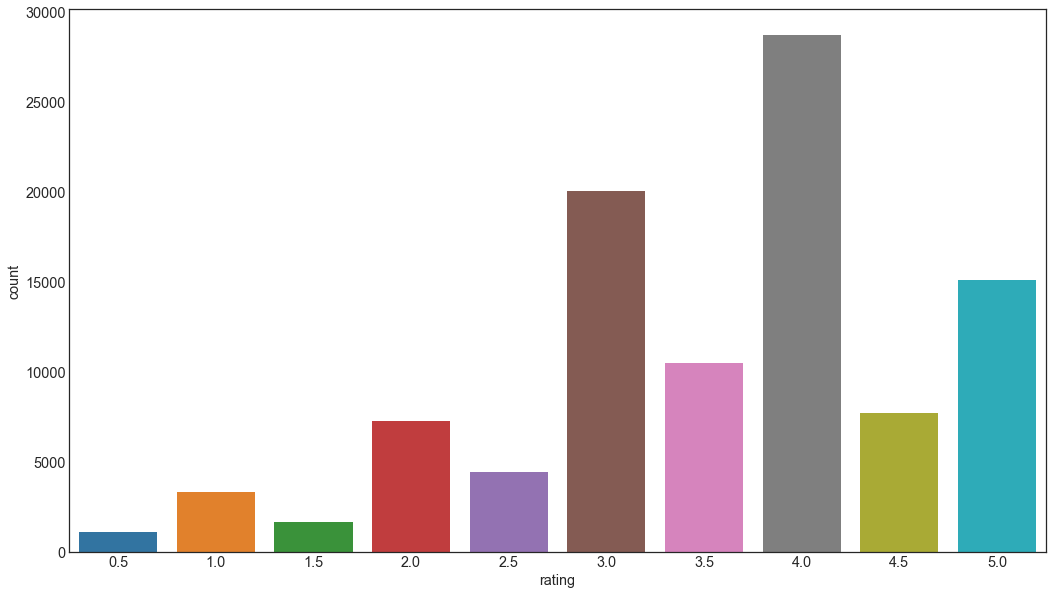

In [6]:
sns.countplot(x='rating',data=ratings)

In [7]:
len(ratings[ratings['rating']==4.0]) / len(ratings) * 100

28.748850045998157

Ratings range from 0.5 to 5.0. Most of the ratings were a 4.0 (28.75%). Interesting to point out that there are a lot of movies with a 5.0 rating.

## Average Movie Rating <a name="average">
***
Let's look at the average rating of each movie and see how it is distributed.

In [8]:
df = pd.merge(ratings,movies[['movieId','title']],on='movieId')

In [9]:
# groupby movieId and get the mean rating
average_rating = pd.DataFrame(df.groupby('movieId')['rating'].mean())

In [10]:
average_rating.rename(columns={'rating': 'avg_rating'},inplace=True)

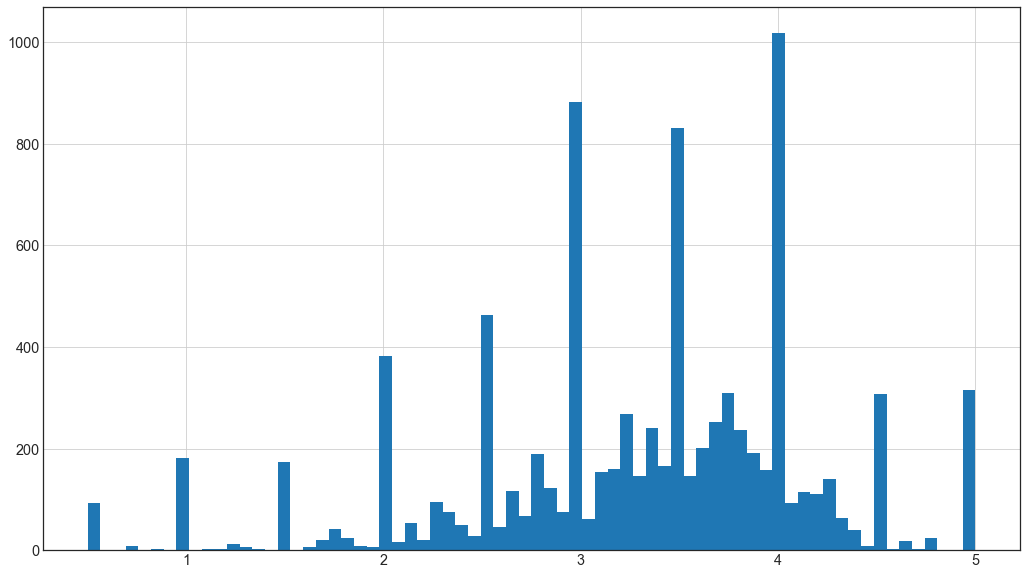

In [11]:
average_rating['avg_rating'].hist(bins=70)

There are peaks every half-star increments from 0.5 stars - 5.0 stars which makes sense since is the way the rating system is in the dataset. It means that most likely the movies in each half-star increment was rated only by one user. Most movies look like they are distributed normally around 3.5-4 stars.

## Rating Count <a name="count">
***
Let's look at the distribution of amount of ratings.

In [12]:
average_rating['rating_count'] = pd.DataFrame(df.groupby('movieId')['rating'].count())
average_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Text(0,0.5,'Count')

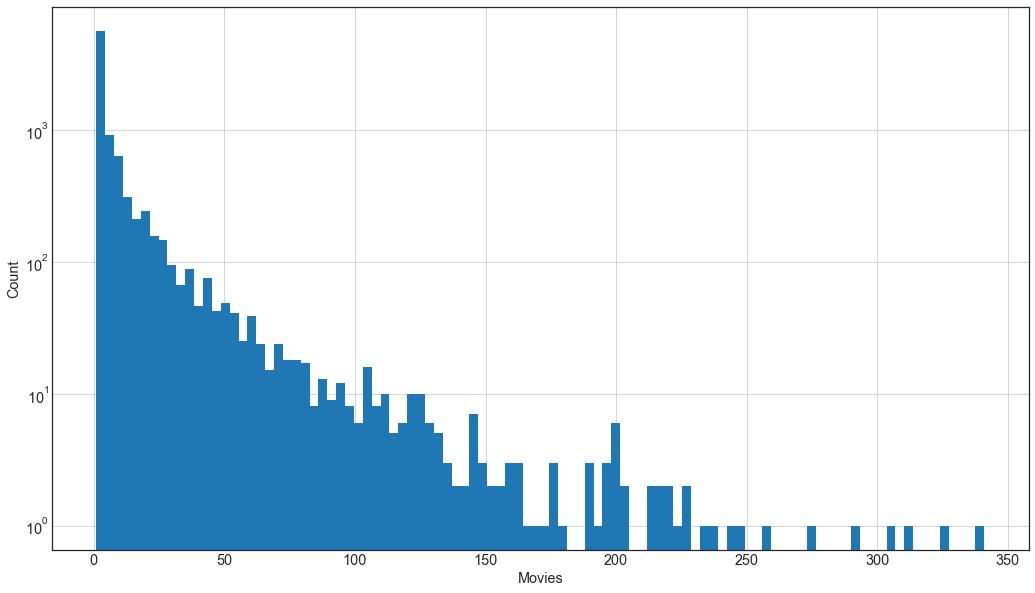

In [13]:
average_rating['rating_count'].hist(bins=100)
plt.yscale('log')
plt.xlabel('Movies')
plt.ylabel('Count')

Most of movies have few ratings making it a sparse dataset. It makes sense since the blockbuster movies are only a few. Now let's see the high rated movies.

## High Rated Movies <a name="highrated">
***
Let's look at the movies that have a high average rating, meaning that most users that watched the movie actually liked it.

In [14]:
# add title column by merging it with the movies dataset
average_rating = average_rating.reset_index().merge(movies[['movieId','title']],on='movieId')

In [15]:
average_rating.sort_values(by='avg_rating',ascending=False).head()

,movieId,avg_rating,rating_count,title
9065,163949,5.0,1,The Beatles: Eight Days a Week - The Touring Y...
7297,71180,5.0,1,Padre padrone (1977)
6629,51471,5.0,1,Amazing Grace (2006)
6662,52617,5.0,1,Woman on the Beach (Haebyeonui yeoin) (2006)
6704,53887,5.0,1,O Lucky Man! (1973)


It is highly unlikely to have a 5.0 star rating even for a popular movie. It means there are movies with just one 5 star rating. To avoid this issue let's get the top 10 movies that have at least 200 ratings. 

In [16]:
average_rating[average_rating['rating_count']>200].sort_values(by='avg_rating',ascending=False).head(10)

,movieId,avg_rating,rating_count,title
284,318,4.487138,311,"Shawshank Redemption, The (1994)"
48,50,4.370647,201,"Usual Suspects, The (1995)"
472,527,4.303279,244,Schindler's List (1993)
535,608,4.256696,224,Fargo (1996)
266,296,4.256173,324,Pulp Fiction (1994)
2288,2858,4.236364,220,American Beauty (1999)
953,1196,4.232906,234,Star Wars: Episode V - The Empire Strikes Back...
232,260,4.221649,291,Star Wars: Episode IV - A New Hope (1977)
955,1198,4.193182,220,Raiders of the Lost Ark (Indiana Jones and the...
2062,2571,4.183398,259,"Matrix, The (1999)"


The [Shawshank Redemption](https://www.imdb.com/title/tt0111161/videoplayer/vi3877612057) is the top rated movie in the dataset. The dataset has movies released up to 2016. However, the most recent movie on the list is from 1999. It gives a sense that the ratings on the dataset come from an older audience.

## Popular Movies <a name="popularmovies">
***
Let's see which were the top 10 movies that most users rated in the dataset.

Text(0,0.5,'Number of Ratings')

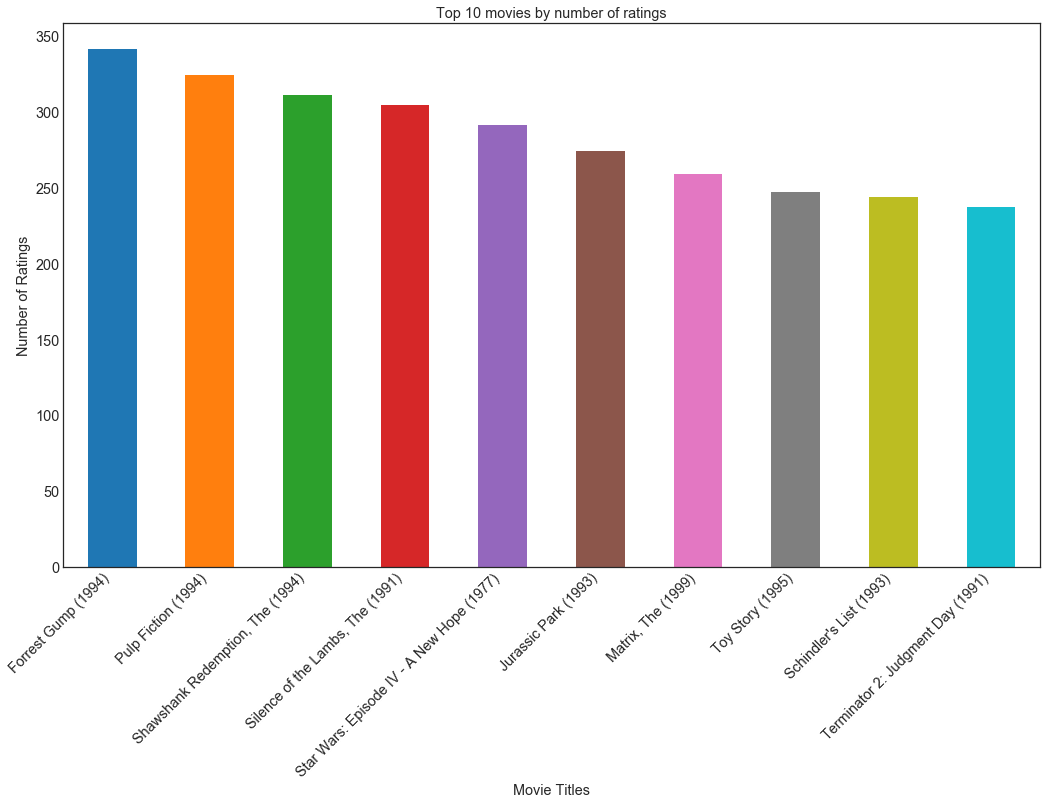

In [22]:
top10 = average_rating.sort_values(by='rating_count',ascending=False)[['title','rating_count']].head(10)
top10.plot(x='title',y='rating_count',kind='bar',legend=None)
plt.xticks(rotation = 45, ha="right")
plt.title('Top 10 movies by number of ratings')
plt.xlabel('Movie Titles')
plt.ylabel('Number of Ratings')

The movies with the most number of ratings in the dataset are Forrest Gump, Pulp Fiction and The Shawshank Redemption. Out of the 3, Shawshank Redemption and Pulp Fiction made it to the top 10 high rated movies in this dataset. 

## Rating Relationship <a name="relationship">
***
Let's look at the distribution or relationship between the actual average rating and the number of ratings.

/Users/andrew/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


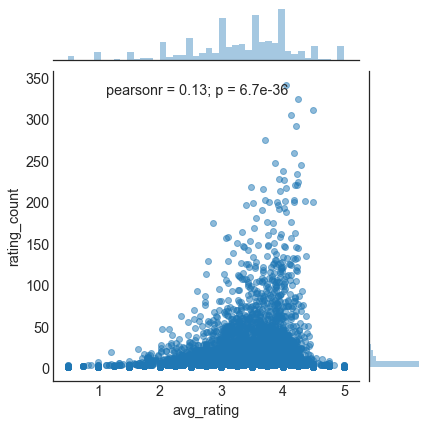

In [23]:
sns.jointplot(x='avg_rating',y='rating_count',data=average_rating,alpha=0.5)

It looks like as the movie gets more total number of ratings, the movie actually has a higher chance of being rated 5 stars. It makes sense since if it is a good movie, more people are going to watch it and rate it. There are outliers close to the 5 star rating and is most likely due to just one person watching the movie and rating it 5 stars. It is highly unlikely for even popular movies to get everyone to rate it 5 stars.

## Ratings Time Series <a name="ratingtime">
***
Let's do a time series analysis of the ratings dataset.

In [24]:
time_series = ratings.set_index('date').resample('D').count()

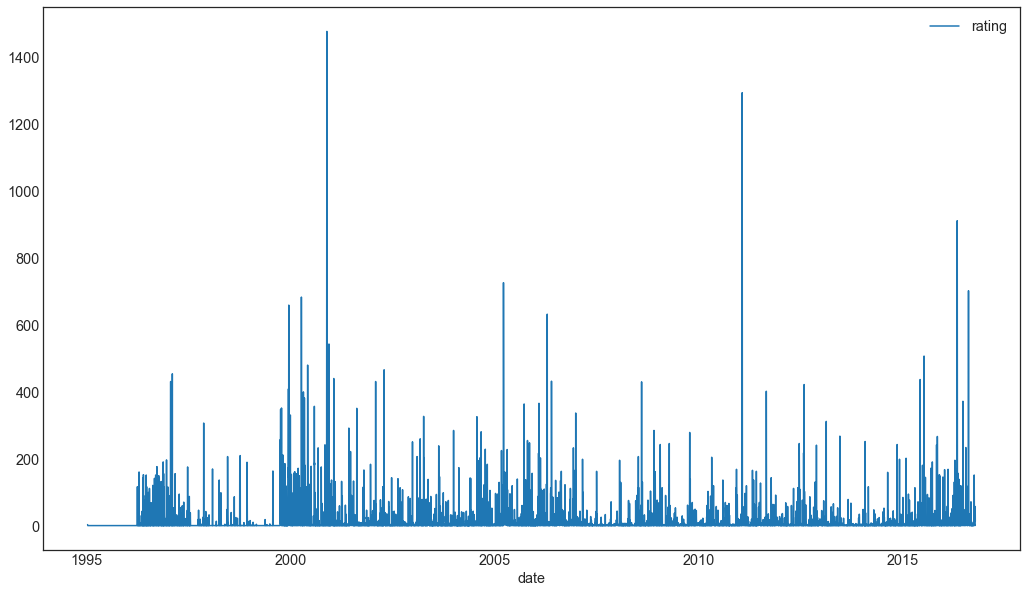

In [25]:
time_series[['rating']].plot()

The highest amount of ratings in one day were more than 1,400. Let's explore more and see why so much traffic on that day.

In [26]:
time_series[time_series['rating']>1400]

,userId,movieId,rating,year,month,day,hour
date,,,,,,,
2000-11-21,1475,1475,1475,1475,1475,1475,1475


In [27]:
time_series.loc['2000-11-18':'2000-11-24']['rating']

date
2000-11-18       0
2000-11-19     220
2000-11-20    1055
2000-11-21    1475
2000-11-22       0
2000-11-23       0
2000-11-24      39
Freq: D, Name: rating, dtype: int64

The highest amount of ratings in one day was on November 21,2000. Interesting to point out that November 21st falls on [Thanksgiving week](https://www.calendar-365.com/calendar/2000/November.html). This might explain the high number of ratings that week. Let's check if that day there was a movie that was rated by most users.

In [32]:
ratings.set_index('date').loc['2000-11-21'].groupby('movieId')['userId'].count().sort_values(ascending=False).head()

movieId
608     4
2395    3
1035    3
2858    3
593     3
Name: userId, dtype: int64

The movie [Fargo(1996)](https://www.imdb.com/title/tt0116282/) was the most rated on November 21st,2000. However, it really does not stand out from the rest. 

In [33]:
ratings.set_index('date').loc['2000-11-21'].groupby('userId')['movieId'].count().sort_values(ascending=False).head()

userId
564    968
547    209
626    150
43      96
387     52
Name: movieId, dtype: int64

On November 21st,2000 *userId 564* rated 967 movies or ~65% of the 1,475 movies.

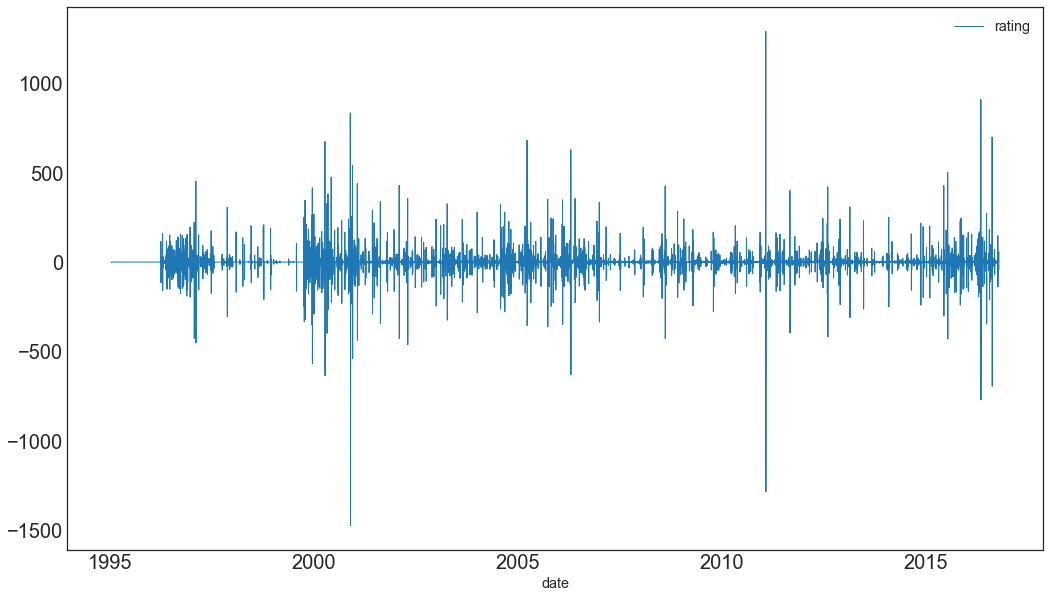

In [34]:
time_series[['rating']].diff().plot(linewidth=1, fontsize=20)

In [35]:
a = time_series[['rating']].diff()
a[a['rating']>1000]

,rating
date,
2011-01-28,1291.0


The biggest spike in the dataset was on 2011 with more than 1,291 rating difference from the previous day.

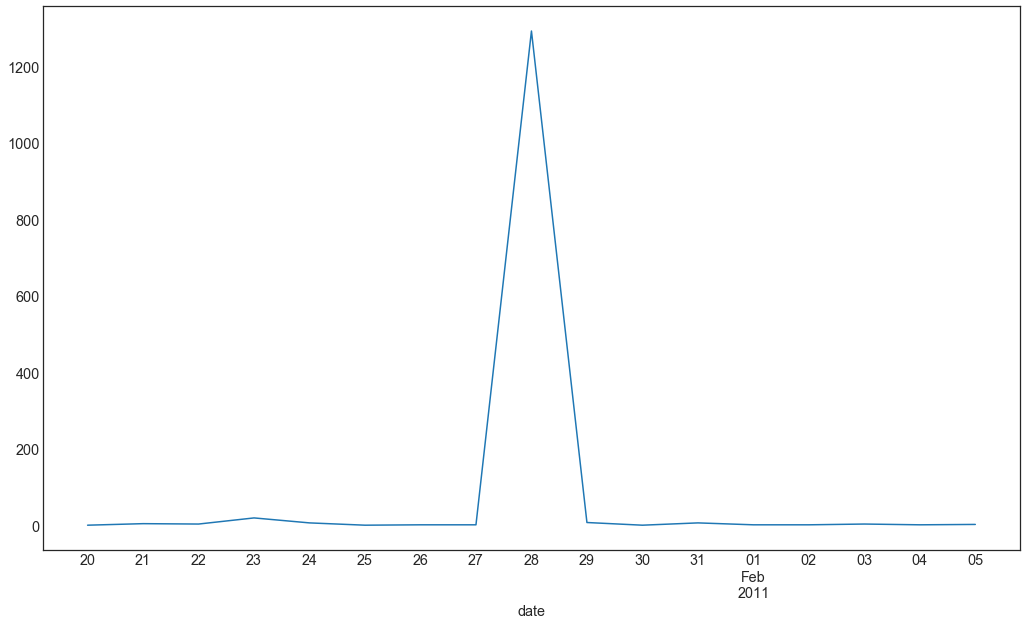

In [36]:
time_series.loc['2011-01-20':'2011-02-05']['rating'].plot()

In [37]:
ratings.set_index('date').loc['2011-01-28'].groupby('movieId')['userId'].count().sort_values(ascending=False).head(3)

movieId
83603    1
2023     1
2125     1
Name: userId, dtype: int64

There was a big increase in the amount of ratings on January 28, 2011. Since previously to that day, the amount of ratings per day was really low. There was no specific movie that stood out that day.

## Users <a name="users">
***
Let's look analyze more the users data.

In [38]:
ratings.groupby('userId').count()['rating'].describe()

count     671.000000
mean      149.037258
std       231.226948
min        20.000000
25%        37.000000
50%        71.000000
75%       161.000000
max      2391.000000
Name: rating, dtype: float64

In [39]:
user_data = pd.DataFrame(df.groupby('userId')['rating'].mean())

In [40]:
user_data['rating_count'] = pd.DataFrame(df.groupby('userId')['rating'].count())

Text(0,0.5,'Number of Users')

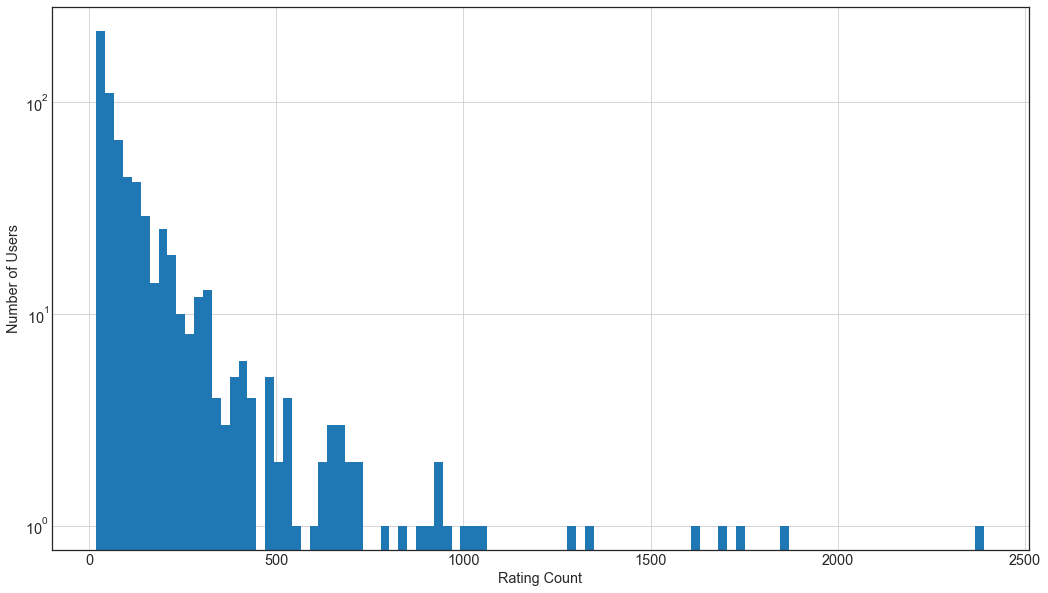

In [41]:
user_data['rating_count'].hist(bins=100)
plt.yscale('log')
plt.xlabel('Rating Count')
plt.ylabel('Number of Users')

There are 100,004 ratings from 671 different users. The average ratings per user is ~149. The max number of ratings by one user is 2,391. The min number of ratings by one user is 20 which makes it a sparse dataset. The graph shows that most users only rated just a few movies, in this case 20 with some outliers rating more than 1,500.

## Average User Rating <a name="averageuser">
***
Let's look at the distribution of user ratings.

In [42]:
user_data.rename(columns={'rating': 'avg_rating'},inplace=True)

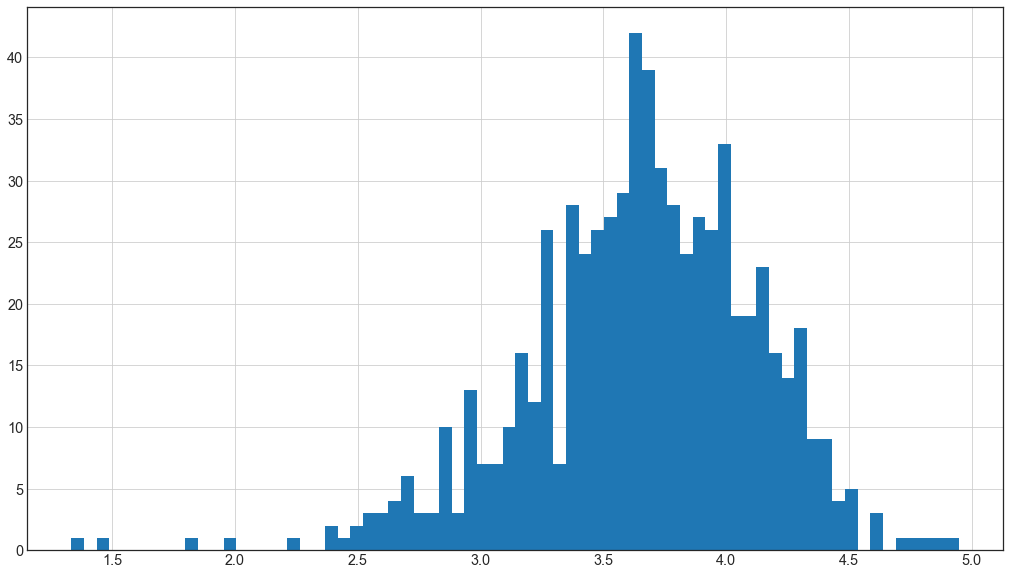

In [43]:
user_data['avg_rating'].hist(bins=70)

The data is normally distributed between 3.5 and 4.0 as it was expected due to the previous Average Movie Rating analysis. 

## Top Users <a name="topusers">
***
Let's see who are the users that rated the most movies.

In [44]:
user_data.sort_values(by='rating_count',ascending=False).head(10)

,avg_rating,rating_count
userId,,
547,3.366792,2391
564,3.552463,1868
624,2.894236,1735
15,2.621765,1700
73,3.374224,1610
452,3.189179,1340
468,2.965918,1291
380,3.366416,1063
311,3.006379,1019


*UserID* 547 rated a total of 2,391 movies. The top 10 users with the most number of ratings have rated approximately more than 1,000 different movies each.

## Movies Produced  <a name="produced">
***
Let's check the total of movies produced each year.

Text(0,0.5,'Years')

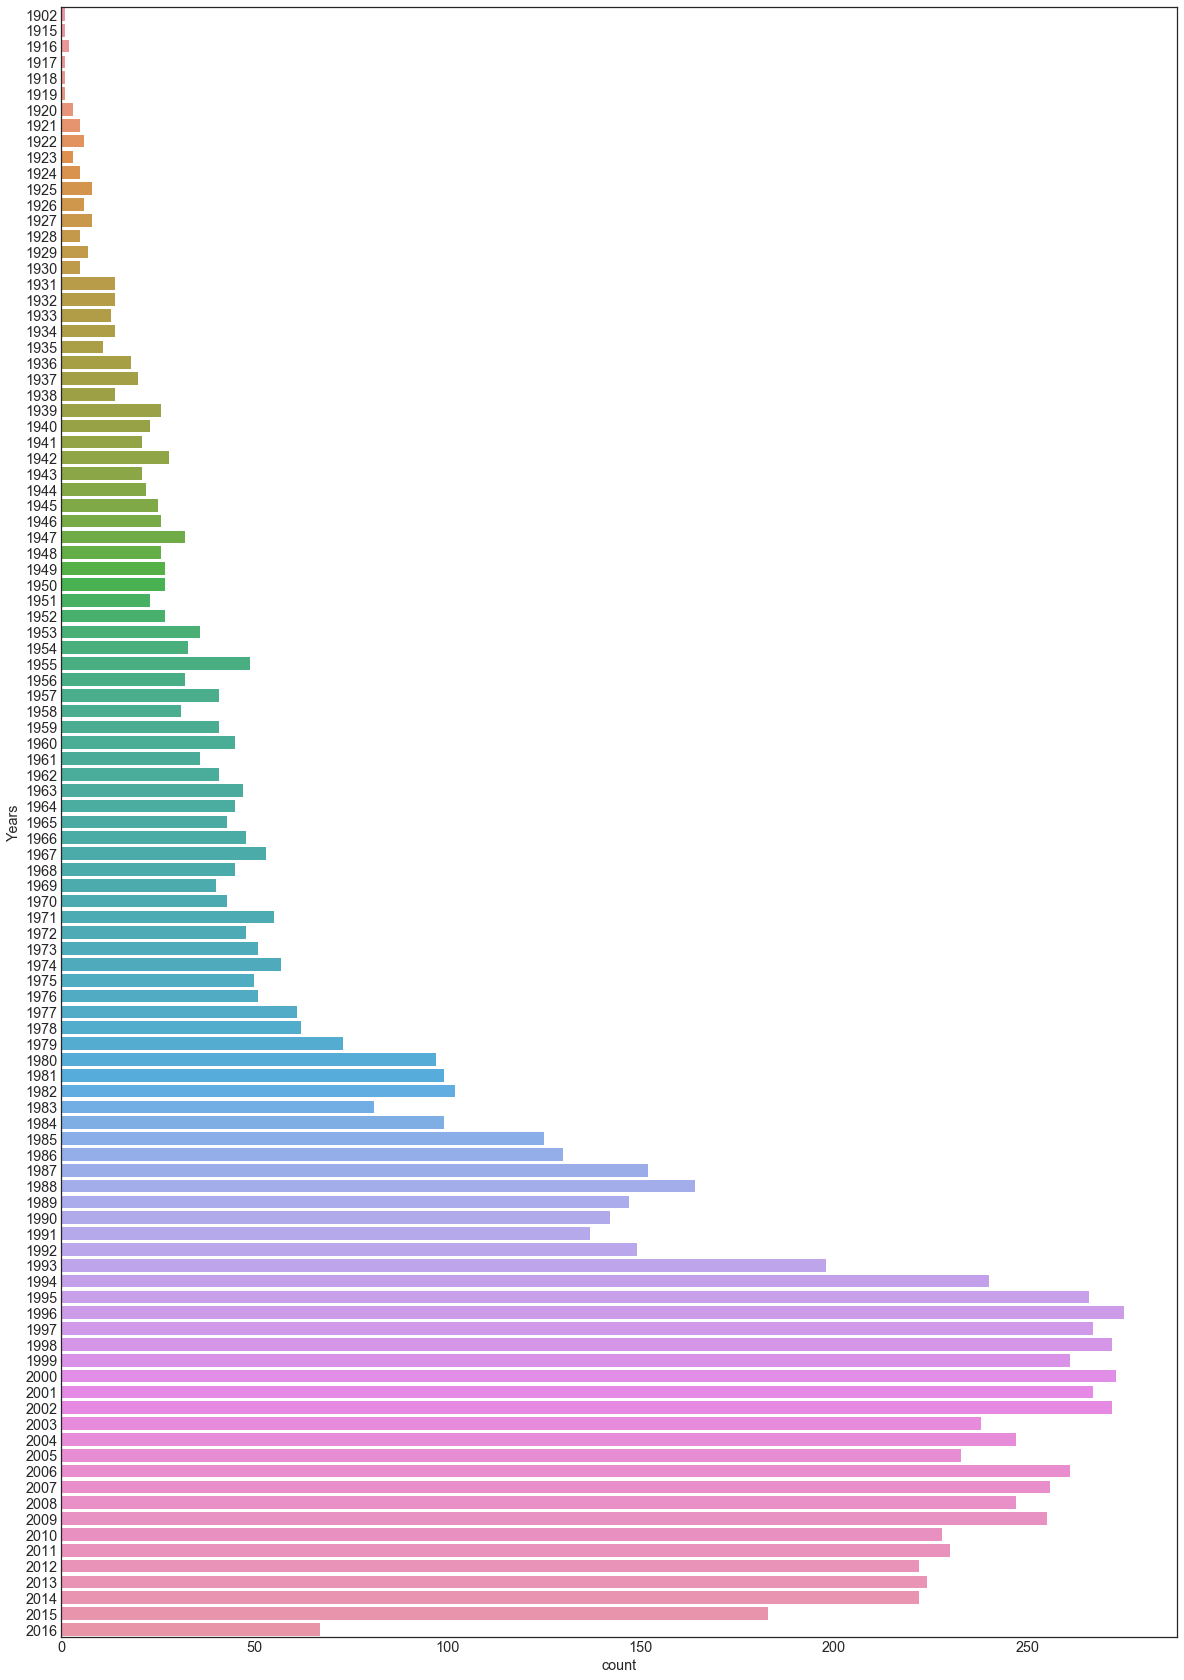

In [45]:
plt.figure(figsize=(20,30))
sns.countplot(y='year',data=movies,orient='h')
plt.ylabel("Years")

In [46]:
movies['year'].value_counts().describe()

count    103.000000
mean      88.592233
std       92.603142
min        1.000000
25%       21.000000
50%       45.000000
75%      148.000000
max      275.000000
Name: year, dtype: float64

The dataset has 114 years of history. Most movies were produced after the 1990s. The max number of movies produced on one year was in 1996 with 275 movie premiers.

## Popular Genres <a name="populargenres">
***
Let's look which genres are the most common in the industry.

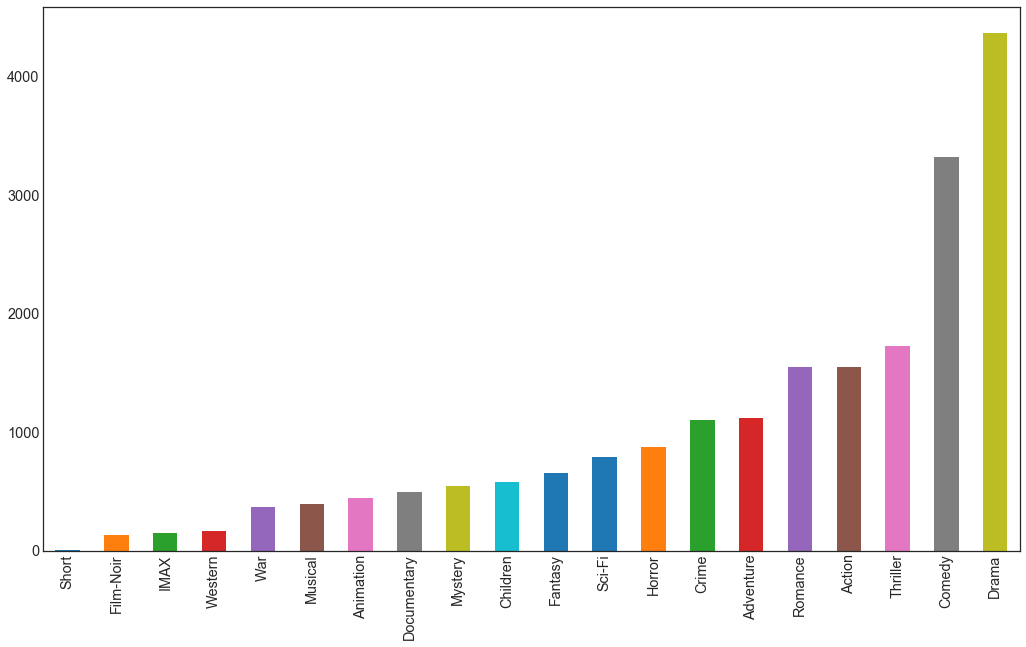

In [47]:
movies.drop(['movieId','title','year'],axis=1).sum().sort_values().plot(kind='bar')

Drama and Comedy are the popular genres in the dataset. Now let's look at niche genres and see if we find interesting insights.

## Historic Trends <a name="historic">
***
History has played an important role in the movie industry. Let's analyze some of the trends.

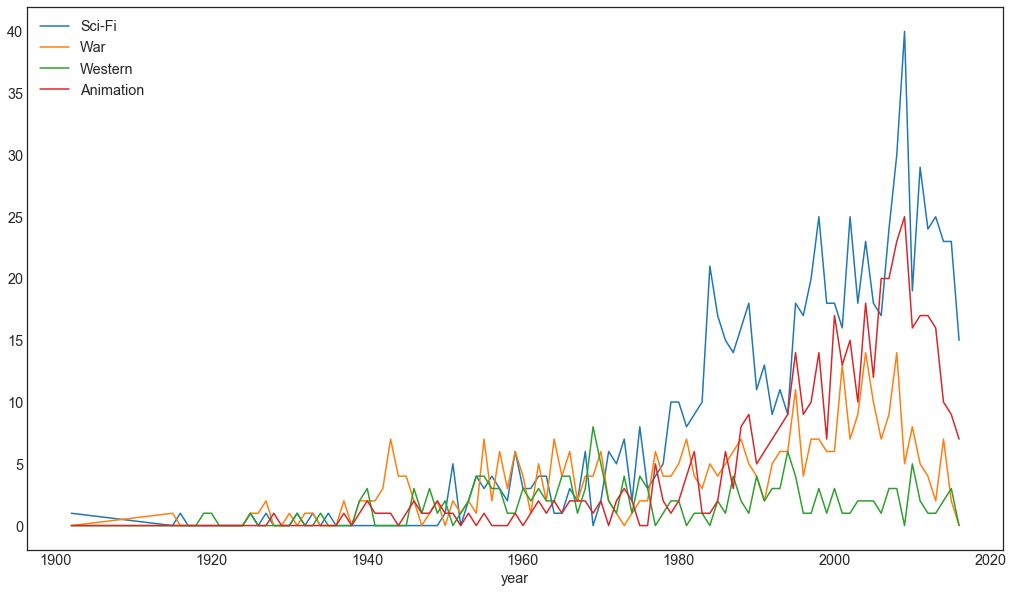

In [48]:
movies.groupby('year').sum()[['Sci-Fi','War','Western','Animation']].plot()

Between 1940 and 1945, there was a rise in the production of War Movies. This means that a historic event, such as [World War II](https://en.wikipedia.org/wiki/World_War_II), was a big influence in the movie industry. Of the 4 genres, Sci-Fi had the fastest growth after the 1970s. One of the events that might have caused this growth was the [Apollo Lunar Missions](https://nssdc.gsfc.nasa.gov/planetary/lunar/apollo.html) between 1968 and 1972. Animation genre's growth starts in the 1990s with more technological advancements and the foundation of one of the most popular animation studios, [Pixar](https://en.wikipedia.org/wiki/Pixar#Early_history). Western movies were more popular than any other genre in the 1930s. After that period, the movie industry focused more on other genres that related to the public.

## Tag Time Series <a name="tagtime">
***
Let's see how the tags were added through out time.

In [49]:
tags['date'] = pd.to_datetime(tags['date'], format='%Y-%m-%d %H:%M:%S')
tag_time_series = tags.set_index('date').resample('D').count()

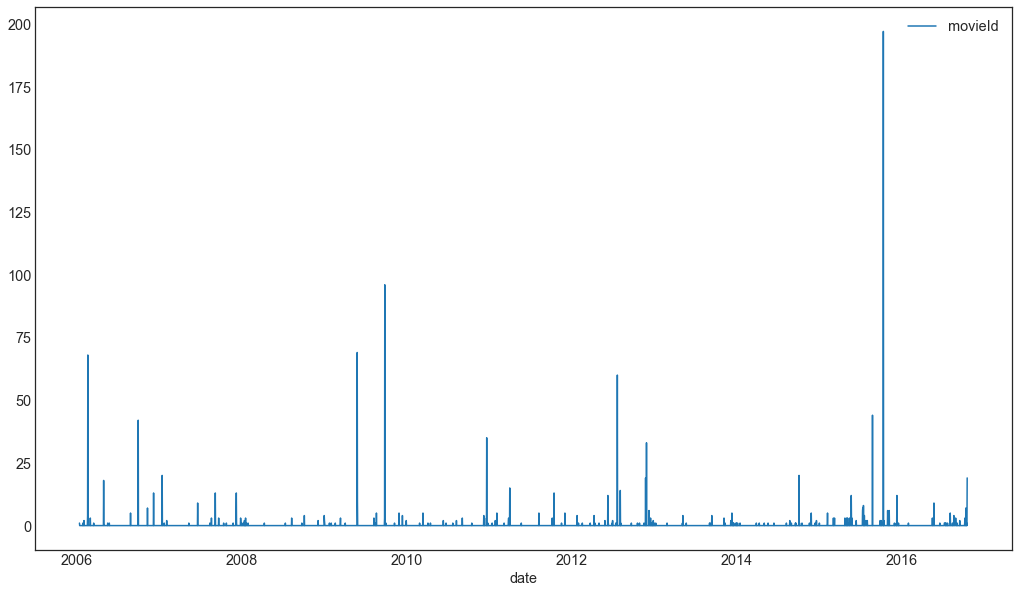

In [50]:
tag_time_series[['movieId']].plot()

In [51]:
tag_time_series[tag_time_series['movieId']>150]['movieId']

date
2015-10-11    197
Freq: D, Name: movieId, dtype: int64

The most movie tags on one day happened on October 11th,2015.

## Top 10 Tags <a name="top10tags">
***
Let's see what are the most popular tags used by users.

Text(0,0.5,'Count')

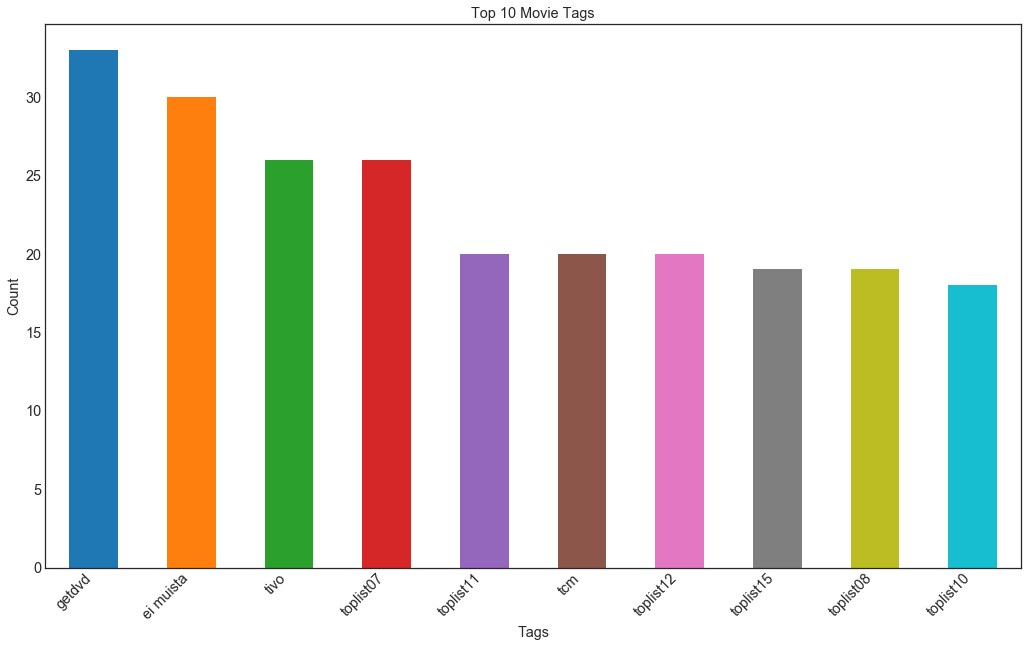

In [52]:
tags.groupby('tag').count()['userId'].sort_values(ascending=False)[:10].plot(kind='bar')
plt.xticks(rotation = 45, ha="right")
plt.title('Top 10 Movie Tags')
plt.xlabel('Tags')
plt.ylabel('Count')

The most popular tag was *getdvd* with 30 different movies with that tag. Let's see how the users used the most popular tag *getdvd*. 

Text(0,0.5,'Count')

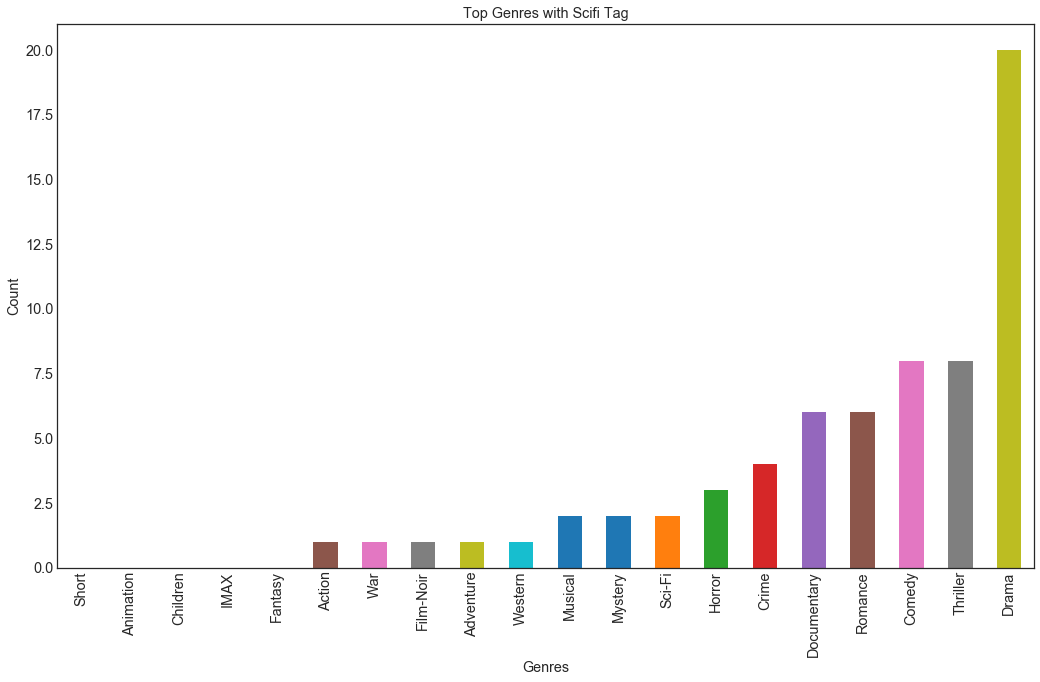

In [54]:
scifi = tags[tags['tag']=='getdvd'][['movieId']]
scifi.merge(movies,on='movieId',how='inner').drop(['movieId','title','year'],axis=1).sum().sort_values().plot(kind='bar')
plt.title('Top Genres with Scifi Tag')
plt.xlabel('Genres')
plt.ylabel('Count')

Most of the movies with the tag *getdvd* are Dramas.

## Relevant Tag per Genre <a name="relevanttag">
***
Looking at how each movie genre is tagged by users is a great way to see if a movie genre can be described using just a few words. 

In [55]:
relevant = movies.drop(['year','title'],axis=1).merge(tags[['movieId','tag']],on='movieId',how='inner').drop(['movieId'],axis=1)

In [56]:
relevant.groupby('tag').sum().idxmax(axis=0)

Action                 ei muista
Adventure              ei muista
Animation                  anime
Children                   funny
Comedy                     funny
Crime                  ei muista
Documentary               getdvd
Drama                     getdvd
Fantasy                    anime
Film-Noir                    tcm
Horror                    getdvd
IMAX           alternate reality
Musical                  musical
Mystery             twist ending
Romance                   comedy
Sci-Fi                     scifi
Short                 1940s feel
Thriller               ei muista
War                     holes40s
Western                 holes60s
dtype: object

Some of the tags are not in english. For example, Action, Crime and Adventure genres were tagged [ei muista](https://translate.google.com/#auto/en/ei%20muista) which means *do not remember* in Finnish according to google translator. Animation, Fantasy, Musical and Sci-Fi genres were tagged with relevant tags that describe the genre correctly.

## Conclusion <a name="conclusion">
***
There were 100,004 ratings from 671 different users. The average number of ratings per user was ~149. The max number of ratings by one user was 2,391. The min number of ratings by one user was 20. The data showed that most users only rated just 20 movies. Ratings ranged from 0.5 to 5.0. Most of the ratings were a 4.0 (28.75%). 

There were peaks every half-star increments from 0.5 stars - 5.0 stars which makes sense since it was the way the rating system is in the dataset. Some movies were rated only by one user. Most movies were normally distributed around 3-3.5 stars.

Only a few movies were considered blockbuster movies with high number of ratings. For example, The [Shawshank Redemption](https://www.imdb.com/title/tt0111161/videoplayer/vi3877612057) was the top rated movie in the dataset and the movie with the most number of ratings.

When comparing average rating with total number of ratings of a movie, the analysis showed that a movie has a higher chance of being rated 5 stars if the movie gets a high total number of ratings.

The highest amount of ratings in one day was 1,475 on November 21,2000. That day *userId 564* took some time to rate 968 movies or ~65% of the 1,475 movies. The top 10 users with the most number of ratings have rated approximately more than 1,000 different movies each. *UserID* 547 rated a total of 2,391 movies.

The dataset had 114 years of history. Most movies were produced after the 1990s. The max number of movies produced was in 1996 with 275 movie premiers according to this dataset. Drama and Comedy were the popular genres in the dataset. Historic events, such as World War II and Apollo Lunar Missions, affected the movie industry by increasing the number of movies of specific genres.

The most popular tag was *getdvd*. Some of the tags were not in english. For example, Action, Crime and Adventure genres were tagged [ei muista](https://translate.google.com/#auto/en/ei%20muista) which means *do not remember* in Finnish according to google translator. Animation, Fantasy, Musical and Sci-Fi genres were tagged with relevant tags that describe the genre correctly.